<p style="font-family: 'Courier New', Courier, monospace; font-size: 50px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Path Loss Measurements in an Indoor Setting: EXPLORATORY DATA ANALYSIS
</p>

<div style="text-align: center;">
    <img src="lorawan.png" alt="LoRaWAN">
    <div style="text-align: right;">Photo Credit: <a href="https://onesight.solutions/wp-content/uploads/2023/10/LoraWAN-Test-Kit-Sales-Tech-Rev-2.pdf">Here</a></div>
</div>


In [1]:
# Libraries/Packages Used:
import os                                  # For accessing environment variables.
from dotenv import load_dotenv             # To load environment variables from an .env file.
import pandas as pd                        # For data manipulation and analysis.
import numpy as np                         # For numerical computations and handling arrays.
import math                                # For mathematical functions.
from datetime import datetime, timedelta   # For handling date and time operations.
import itertools                           # To cycle through iterables.
import matplotlib.gridspec as gridspec     # For grid layout management.
from itertools import cycle                # To cycle through specific iterables like colors.
import matplotlib.pyplot as plt            # For creating static visualizations.
from matplotlib.lines import Line2D        # For custom lines in plots.
from collections import OrderedDict        # For maintaining order in unique legend entries
import seaborn as sns                      # For statistical data visualization based on matplotlib.
import plotly.graph_objs as go             # For creating interactive visualizations.
from plotly.subplots import make_subplots  # For creating interactive subplots.

import plotly.io as pio  # Plotly I/O for rendering settings.
pio.renderers.default = 'jupyterlab'  # Set renderer to JupyterLab.

In [2]:
# Load environment variables from the .env file
load_dotenv()

# Run the Data_Querying notebook to fetch and prepare the data
# %run "Data_Querying.ipynb"

True

In [3]:
# Read data from a local CSV file
new_df = pd.read_csv('../all_data_files/combined_measurements_data.csv', low_memory=False)

# Print the info about the combined DataFrame
print("\nInfo of Combined DataFrame:\n")
new_df.info()
new_df.head()


Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027566 entries, 0 to 1027565
Data columns (total 71 columns):
 #   Column                                                   Non-Null Count    Dtype  
---  ------                                                   --------------    -----  
 0   time                                                     1027566 non-null  object 
 1   correlation_ids_0                                        1027566 non-null  object 
 2   device_id                                                1027566 non-null  object 
 3   end_device_ids_application_ids_application_id            1027566 non-null  object 
 4   end_device_ids_dev_addr                                  1027566 non-null  object 
 5   end_device_ids_dev_eui                                   1027566 non-null  object 
 6   end_device_ids_device_id                                 1027566 non-null  object 
 7   end_device_ids_join_eui                                  102

,time,correlation_ids_0,device_id,end_device_ids_application_ids_application_id,end_device_ids_dev_addr,end_device_ids_dev_eui,end_device_ids_device_id,end_device_ids_join_eui,received_at,uplink_message_confirmed,...,uplink_message_settings_data_rate_lora_coding_rate,uplink_message_settings_data_rate_lora_spreading_factor,uplink_message_settings_frequency,uplink_message_settings_time,uplink_message_settings_timestamp,uplink_message_version_ids_band_id,uplink_message_version_ids_brand_id,uplink_message_version_ids_firmware_version,uplink_message_version_ids_hardware_version,uplink_message_version_ids_model_id
0,2024-09-26 13:00:52.541686+02:00,gs:uplink:01J8PZVAYFB1Y3CDR10MCHH43E,up,pilot-test,260B46AE,A8610A3230257716,pilotdevice03,0,2024-09-26T11:00:52.510624152Z,True,...,4/5,10.0,867900000,2024-09-26T11:00:52.268982Z,2.627461e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310
1,2024-09-26 13:00:52.542462+02:00,gs:uplink:01J8PZVAYFB1Y3CDR10MCHH43E,up,pilot-test,260B46AE,A8610A3230257716,pilotdevice03,0,2024-09-26T11:00:52.510624152Z,True,...,4/5,10.0,867900000,2024-09-26T11:00:52.268982Z,2.627461e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310
2,2024-09-26 13:01:08.336258+02:00,gs:uplink:01J8PZVTC2YGT0JW8R7XYW7J9D,up,pilot-test,260B41EC,A8610A34362A8316,pilotdevice,0,2024-09-26T11:01:08.305577574Z,True,...,4/5,9.0,868100000,2024-09-26T11:01:08.065003Z,2.643257e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310
3,2024-09-26 13:01:08.338296+02:00,gs:uplink:01J8PZVTC2YGT0JW8R7XYW7J9D,up,pilot-test,260B41EC,A8610A34362A8316,pilotdevice,0,2024-09-26T11:01:08.305577574Z,True,...,4/5,9.0,868100000,2024-09-26T11:01:08.065003Z,2.643257e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310
4,2024-09-26 13:01:14.477162+02:00,gs:uplink:01J8PZW0BX58S4QHK38X4A9KHJ,up,pilot-test,260B92C1,A8610A3436385E17,pilotdevice01,0,2024-09-26T11:01:14.446529545Z,True,...,4/5,9.0,867500000,2024-09-26T11:01:14.203163Z,2.649395e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Creating the assorted/aggregated measurements Dataframe, i.e. keeping important columns, mapping necessary info too.
</p>

In [4]:
# Columns to keep and their new names for better readability
columns_to_keep = {
    'time': 'time',
    'end_device_ids_device_id': 'device_id',
    'uplink_message_decoded_payload_co2': 'co2',
    'uplink_message_decoded_payload_humidity': 'humidity',
    'uplink_message_decoded_payload_pm25': 'pm25',
    'uplink_message_decoded_payload_pressure': 'pressure',
    'uplink_message_decoded_payload_temperature': 'temperature',
    'uplink_message_rx_metadata_0_rssi': 'rssi',
    'uplink_message_rx_metadata_0_snr': 'snr',
    'uplink_message_settings_data_rate_lora_spreading_factor': 'SF',
    'uplink_message_settings_frequency': 'frequency',
    'uplink_message_f_cnt': 'f_count',
    'uplink_message_decoded_payload_packetCount' : 'p_count',
    'uplink_message_consumed_airtime' : 'toa'
}

# Select and rename columns to keep the dataset clean
cleaned_df = new_df[list(columns_to_keep.keys())].rename(columns=columns_to_keep)

# Add a 'distance' column based on device_id values
distance_map = {
    'pilotdevice'  : 10,
    'pilotdevice01': 8,
    'pilotdevice02': 23,
    'pilotdevice03': 18,
    'pilotdevice04': 37,
    'pilotdevice05': 40
}

# Map the distances to the devices
cleaned_df['distance'] = cleaned_df['device_id'].map(distance_map)

# Define the mapping for c_walls and w_walls
wall_counts_map = {
    'pilotdevice': (0, 0),
    'pilotdevice01': (1, 0),
    'pilotdevice02': (0, 2),
    'pilotdevice03': (1, 2),
    'pilotdevice04': (0, 5),
    'pilotdevice05': (2, 2)
}

# Map the c_walls and w_walls columns using the provided tuple mapping
cleaned_df[['c_walls', 'w_walls']] = cleaned_df['device_id'].map(wall_counts_map).apply(pd.Series)

# Shorten the device names for easier reference
device_name_map = {
    'pilotdevice'  : 'ED0',
    'pilotdevice01': 'ED1',
    'pilotdevice02': 'ED2',
    'pilotdevice03': 'ED3',
    'pilotdevice04': 'ED4',
    'pilotdevice05': 'ED5'
}

# Apply the name mapping so that devices now use shorter names
cleaned_df['device_id'] = cleaned_df['device_id'].map(device_name_map)

# Convert the frequency column to numeric (handling any errors) and convert to MHz
cleaned_df['frequency'] = pd.to_numeric(cleaned_df['frequency'], errors='coerce')
cleaned_df['frequency'] = cleaned_df['frequency'] / 1e6  # Hz to MHz

# Clean up the 'toa' column by removing the 's' at the end and converting to float
cleaned_df['toa'] = cleaned_df['toa'].str.rstrip('s').astype(float)

# Adding the 'experimental_PL' column based on the provided constants and formula
cleaned_df = cleaned_df.assign(
    exp_pl = 14 - 1 + 1.4 + 3 - cleaned_df['rssi']  
    # Using the exact values: tx_p=14, tx_cl=1, tx_ag=1.4, rx_ag=3, tx_cl=0
)

# Calculate Noise Power (n_power) in dBm
cleaned_df = cleaned_df.assign(
    n_power = cleaned_df['rssi'] - 10 * np.log10(np.power(10, cleaned_df['snr'] / 10) + 1)
)

# Calculate Effective Signal Power (esp) in dBm
cleaned_df = cleaned_df.assign(
    esp = cleaned_df['n_power'] + cleaned_df['snr']
)

#  'SF' from float to int
cleaned_df['SF'] = cleaned_df['SF'].astype('int64')

# Save the cleaned and aggregated data to a CSV file 
cleaned_df.to_csv('../all_data_files/aggregated_measurements_data.csv', index=False)

# Display DataFrame information to confirm everything
cleaned_df.info()
cleaned_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027566 entries, 0 to 1027565
Data columns (total 20 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   time         1027566 non-null  object 
 1   device_id    1027566 non-null  object 
 2   co2          1027566 non-null  float64
 3   humidity     1027566 non-null  float64
 4   pm25         1027566 non-null  float64
 5   pressure     1027566 non-null  float64
 6   temperature  1027566 non-null  float64
 7   rssi         1027566 non-null  float64
 8   snr          1026452 non-null  float64
 9   SF           1027566 non-null  int64  
 10  frequency    1027566 non-null  float64
 11  f_count      1027554 non-null  float64
 12  p_count      1027566 non-null  float64
 13  toa          1027566 non-null  float64
 14  distance     1027566 non-null  int64  
 15  c_walls      1027566 non-null  int64  
 16  w_walls      1027566 non-null  int64  
 17  exp_pl       1027566 non-null  float64
 18  n_

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 13:00:52.541686+02:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10,867.9,94.0,104.0,0.452608,18,1,2,88.4,-83.454107,-71.254107
1,2024-09-26 13:00:52.542462+02:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10,867.9,94.0,104.0,0.452608,18,1,2,88.4,-83.454107,-71.254107
2,2024-09-26 13:01:08.336258+02:00,ED0,541.0,49.34,0.46,299.70,24.57,-52.0,13.2,9,868.1,81.0,108.0,0.246784,10,0,0,69.4,-65.403045,-52.203045
3,2024-09-26 13:01:08.338296+02:00,ED0,541.0,49.34,0.46,299.70,24.57,-52.0,13.2,9,868.1,81.0,108.0,0.246784,10,0,0,69.4,-65.403045,-52.203045
4,2024-09-26 13:01:14.477162+02:00,ED1,475.0,45.28,0.23,300.73,25.63,-58.0,8.5,9,867.5,80.0,106.0,0.246784,8,1,0,75.4,-67.073822,-58.573822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027561,2024-12-28 11:30:41.920946+01:00,ED5,496.0,40.86,3.48,333.99,16.60,-104.0,3.0,7,868.3,85274.0,93387.0,0.071936,40,2,2,121.4,-108.764349,-105.764349
1027562,2024-12-28 11:30:44.745876+01:00,ED1,497.0,35.61,2.00,334.38,20.20,-57.0,8.5,8,867.5,83129.0,93352.0,0.133632,8,1,0,74.4,-66.073822,-57.573822
1027563,2024-12-28 11:31:18.637483+01:00,ED0,487.0,40.33,1.41,333.35,17.01,-118.0,-3.0,12,868.1,83819.0,93362.0,1.810432,10,0,0,135.4,-119.764349,-122.764349
1027564,2024-12-28 11:31:30.372502+01:00,ED2,461.0,41.39,2.04,334.82,15.32,-66.0,11.2,11,868.1,84153.0,93369.0,0.987136,23,0,2,83.4,-77.517549,-66.317549


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Checking (abnormal) Anomalies with BOX PLOTS
</p>

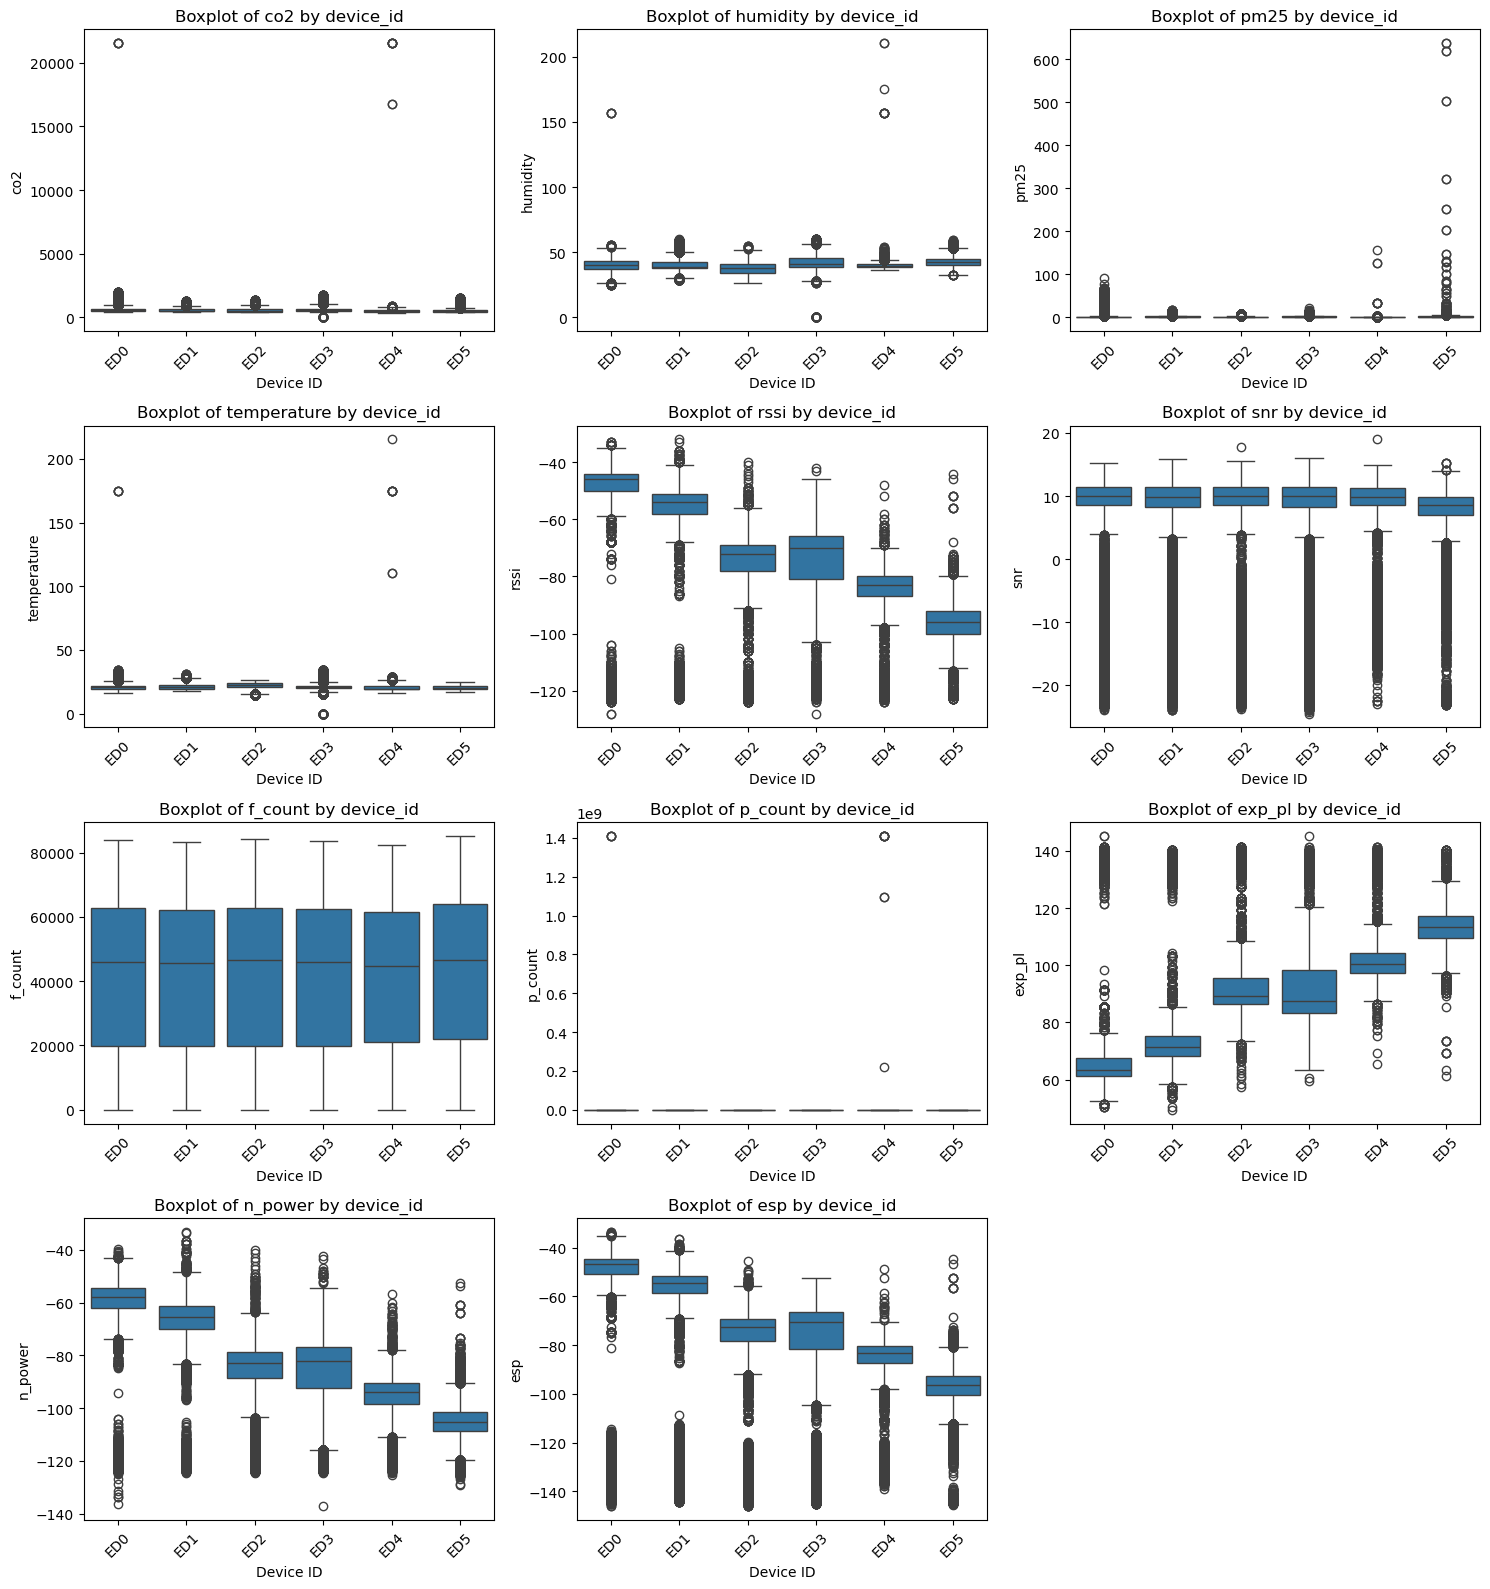

In [5]:
# Columns to exclude
exclude_cols = ['c_walls', 'w_walls', 'frequency', 'SF', 'toa', 'distance', 'pressure']

# Select numeric columns excluding 'f_count' and 'p_count'
numeric_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.drop(exclude_cols)

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5']

# Ensure 'device_id' is a categorical type with the specified order
cleaned_df.loc[:, 'device_id'] = pd.Categorical(cleaned_df['device_id'], categories=desired_order, ordered=True)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(x='device_id', y=col, data=cleaned_df, order=desired_order)
    plt.title(f'Boxplot of {col} by device_id')
    plt.xlabel('Device ID')
    plt.ylabel(col)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Packet Delivery Ratio (PDR)
</p>

In [6]:
# Remove rows with a p_count above 2M ('abnormal outlier')
cleaned_df = cleaned_df[~(cleaned_df['p_count'] > 2000000)]

# Grouping data by device_id
grouped = cleaned_df.groupby('device_id')

# Calculating the total sent and received packets
pdr_table = grouped.agg(
    total_sent_packets=('p_count', 'max'),
    received_packets=('f_count', 'max')
)

# Calculating the PDR
pdr_table['PDR (%)'] = (pdr_table['received_packets'] / pdr_table['total_sent_packets']) * 100

# Displaying the result as a table
pdr_table


,total_sent_packets,received_packets,PDR (%)
device_id,,,
ED0,93362.0,83819.0,89.778497
ED1,93352.0,83129.0,89.048976
ED2,93369.0,84153.0,90.129486
ED3,93360.0,83507.0,89.446230
ED4,93332.0,82327.0,88.208760
ED5,93387.0,85274.0,91.312495


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Channel Usage Transmissions Confirmation / Check
</p>

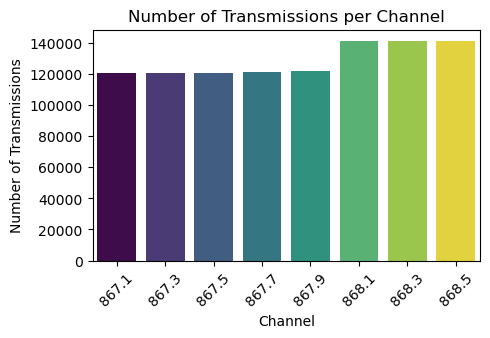

In [7]:
# Count transmissions per channel
channel_counts = cleaned_df['frequency'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(5, 3))
sns.barplot(
    x=channel_counts.index,
    y=channel_counts.values,
    hue=channel_counts.index,      # 'x' to 'hue'
    palette='viridis',
    dodge=False,                  
    legend=False              
)
plt.title('Number of Transmissions per Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Transmissions')
plt.xticks(rotation=45)
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Visual Dataframe Cleaning
</p>

In [8]:
# Remove rows with a temperature above 80
cleaned_df = cleaned_df[~(cleaned_df['temperature'] > 80)]

# Remove rows with humidity below 100
cleaned_df = cleaned_df[~(cleaned_df['humidity'] > 100)]

# Remove rows with a CO2 above 5000
cleaned_df = cleaned_df[~(cleaned_df['co2'] > 5000)]

# Remove rows with a CO2 = 0
cleaned_df = cleaned_df[~(cleaned_df['co2'] == 0)]

# Save all data to csv
cleaned_df.to_csv('../all_data_files/visually_cleaned_df.csv', index=False)

# Display the cleaned Dataframe Info
print("\nInfo of Combined DataFrame:\n")
cleaned_df.info()


Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
Index: 1027488 entries, 0 to 1027565
Data columns (total 20 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   time         1027488 non-null  object 
 1   device_id    1027488 non-null  object 
 2   co2          1027488 non-null  float64
 3   humidity     1027488 non-null  float64
 4   pm25         1027488 non-null  float64
 5   pressure     1027488 non-null  float64
 6   temperature  1027488 non-null  float64
 7   rssi         1027488 non-null  float64
 8   snr          1026374 non-null  float64
 9   SF           1027488 non-null  int64  
 10  frequency    1027488 non-null  float64
 11  f_count      1027476 non-null  float64
 12  p_count      1027488 non-null  float64
 13  toa          1027488 non-null  float64
 14  distance     1027488 non-null  int64  
 15  c_walls      1027488 non-null  int64  
 16  w_walls      1027488 non-null  int64  
 17  exp_pl       1027488 

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
   BOX PLOTS after physical elimination of 'abnormal' anomalies
</p>

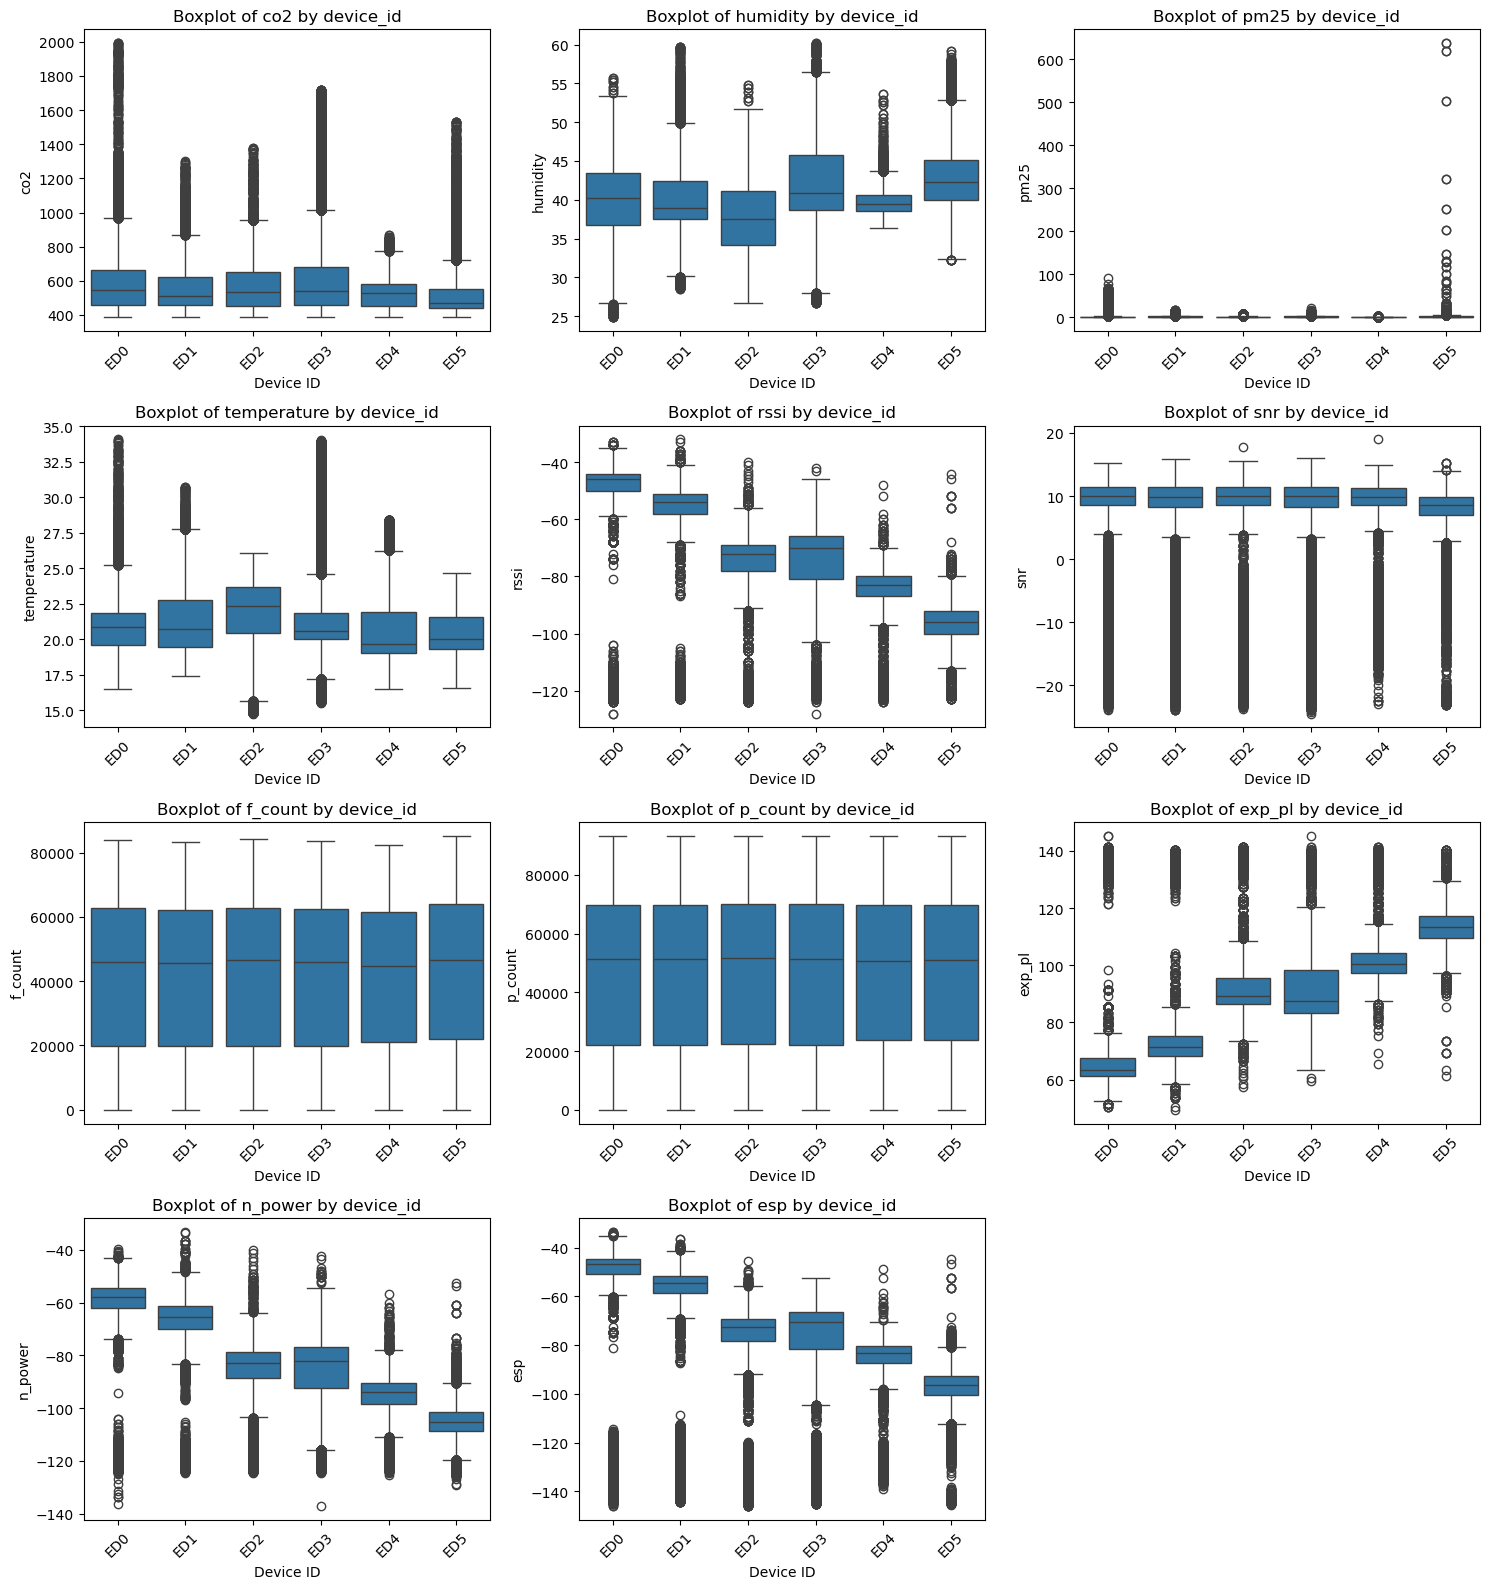

In [9]:
# Columns to exclude
exclude_cols = ['c_walls', 'w_walls', 'frequency', 'SF', 'toa', 'distance', 'pressure']

# Select numeric columns excluding 'f_count' and 'p_count'
numeric_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.drop(exclude_cols)

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5']

# Ensure 'device_id' is a categorical type with the specified order
cleaned_df.loc[:, 'device_id'] = pd.Categorical(cleaned_df['device_id'], categories=desired_order, ordered=True)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(x='device_id', y=col, data=cleaned_df, order=desired_order)
    plt.title(f'Boxplot of {col} by device_id')
    plt.xlabel('Device ID')
    plt.ylabel(col)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Plot for Some Dataframe variables over time
</p>

In [10]:
def plot_sensor_readings(cleaned_df, row_map):
    """
    Plots sensor readings by grouping devices and assigning colors dynamically.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data.
    - row_map (dict): Mapping of sensor parameters to subplot rows.
    """
    # Create subplots dynamically based on the row_map provided
    fig = make_subplots(
        rows=len(row_map), cols=1, 
        subplot_titles=[f'{param.title()} Readings Over Time' for param in row_map]
    )

    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['green', 'red', 'blue', 'purple', 'orange', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])
    
    # Group by unique device IDs and assign colors dynamically
    device_colors = {device: next(color_pool) for device in cleaned_df['device_id'].unique()}

    # Set to track which devices have already been added to the legend
    devices_in_legend = set()

    # Plotting for each parameter and each device
    for param, row in row_map.items():
        for device, color in device_colors.items():
            # Filter data for the specific device
            data = cleaned_df[cleaned_df['device_id'] == device]
            
            # Add a trace for each parameter for the current device
            fig.add_trace(
                go.Scatter(
                    x=data['time'], 
                    y=data[param], 
                    mode='lines',  # Line plot
                    name=f"{device}" if device not in devices_in_legend else None,  # Device to legend once
                    line=dict(color=color),
                    showlegend=device not in devices_in_legend  # Show legend if the device hasn't been added yet
                ),
                row=row, col=1  # Place in the correct subplot
            )

            # Mark the device as added to the legend
            devices_in_legend.add(device)

    # Update layout with fixed height and other settings
    fig.update_layout(
        height=1800,  # Fixed height to accommodate all subplots
        showlegend=True,  # Show legend
        title_text="Sensor Readings Over Time",  # Overall plot title
        legend=dict(title="Devices", x=1.05, y=1)  # Adjusting legend position
    )

    # Show the plot
    fig.show()

# Example usage:
# Define the row mapping for parameters; can be modified as needed
row_map = {
    'temperature': 1, 'humidity': 2, 'co2': 3, 'pm25': 4, 
    'pressure': 5, 'rssi': 6, 'snr': 7
}

# Calling the function with the cleaned DataFrame and row_map
#plot_sensor_readings(cleaned_df, row_map)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Statistical Description
</p>

In [13]:
# Generate statistical description and remove unnecessary columns
stat_description = cleaned_df.describe().transpose().drop(
    columns=['count']).drop(['f_count', 'p_count'])

# Define the exact order of metrics and units for alignment
metrics = [
    'co2', 'humidity', 'pm25', 'pressure', 'temperature', 
    'rssi', 'snr', 'SF', 'frequency', 'toa', 
    'distance', 'c_walls', 'w_walls', 'exp_pl', 'n_power', 'esp'
]
units = [
    'ppm', '%', 'µg/m³', 'hPa', '°C', 'dBm', 'dB', 'bit/sym', 'MHz', 's', 
    'm', '', '', 'dB', 'dB', 'dBm'
]

# Set index explicitly to ensure correct row order
stat_description = stat_description.loc[metrics]

# Add units as a separate column
stat_description.insert(0, 'Unit', units)

# Rename columns accordingly
stat_description = stat_description.rename(columns={
    'mean': 'Mean',
    'std': 'STD (σ)',
    'min': 'Min',
    '25%': '1ˢᵗ Quartile (25%)', 
    '50%': 'Median', 
    '75%': '3ʳᵈ Quartile (75%)',
    'max': 'Max'
})

# Add "Field" as a regular column to align with other columns
stat_description.reset_index(inplace=True)
stat_description = stat_description.rename(columns={'index': 'Field'})

# Remove the automatic index numbering in the output
stat_description.index = [''] * len(stat_description)

# Format floating-point numbers to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Save to Excel file without automatic indices
excel_path = "statistical_description.xlsx"
stat_description.to_excel(excel_path, index=False)

# Display the updated statistical description
stat_description

,Field,Unit,Mean,STD (σ),Min,1ˢᵗ Quartile (25%),Median,3ʳᵈ Quartile (75%),Max
,co2,ppm,555.398,136.109,386.000,452.000,516.000,624.000,1993.000
,humidity,%,40.652,4.778,24.860,37.680,39.940,43.320,60.190
,pm25,µg/m³,1.392,2.249,0.000,0.510,1.010,1.800,637.710
,pressure,hPa,323.933,10.251,286.910,318.070,325.760,332.350,342.810
,temperature,°C,21.010,2.124,14.760,19.460,20.640,22.200,34.090
,rssi,dBm,-76.335,22.441,-128.000,-92.000,-75.000,-56.000,-32.000
,snr,dB,7.763,6.838,-24.500,8.000,9.500,11.200,19.000
,SF,bit/sym,9.322,1.688,7.000,8.000,9.000,11.000,12.000
,frequency,MHz,867.830,0.461,867.100,867.500,867.900,868.300,868.500
,toa,s,0.557,0.591,0.072,0.134,0.247,0.987,1.974


<Figure size 2000x2000 with 0 Axes>

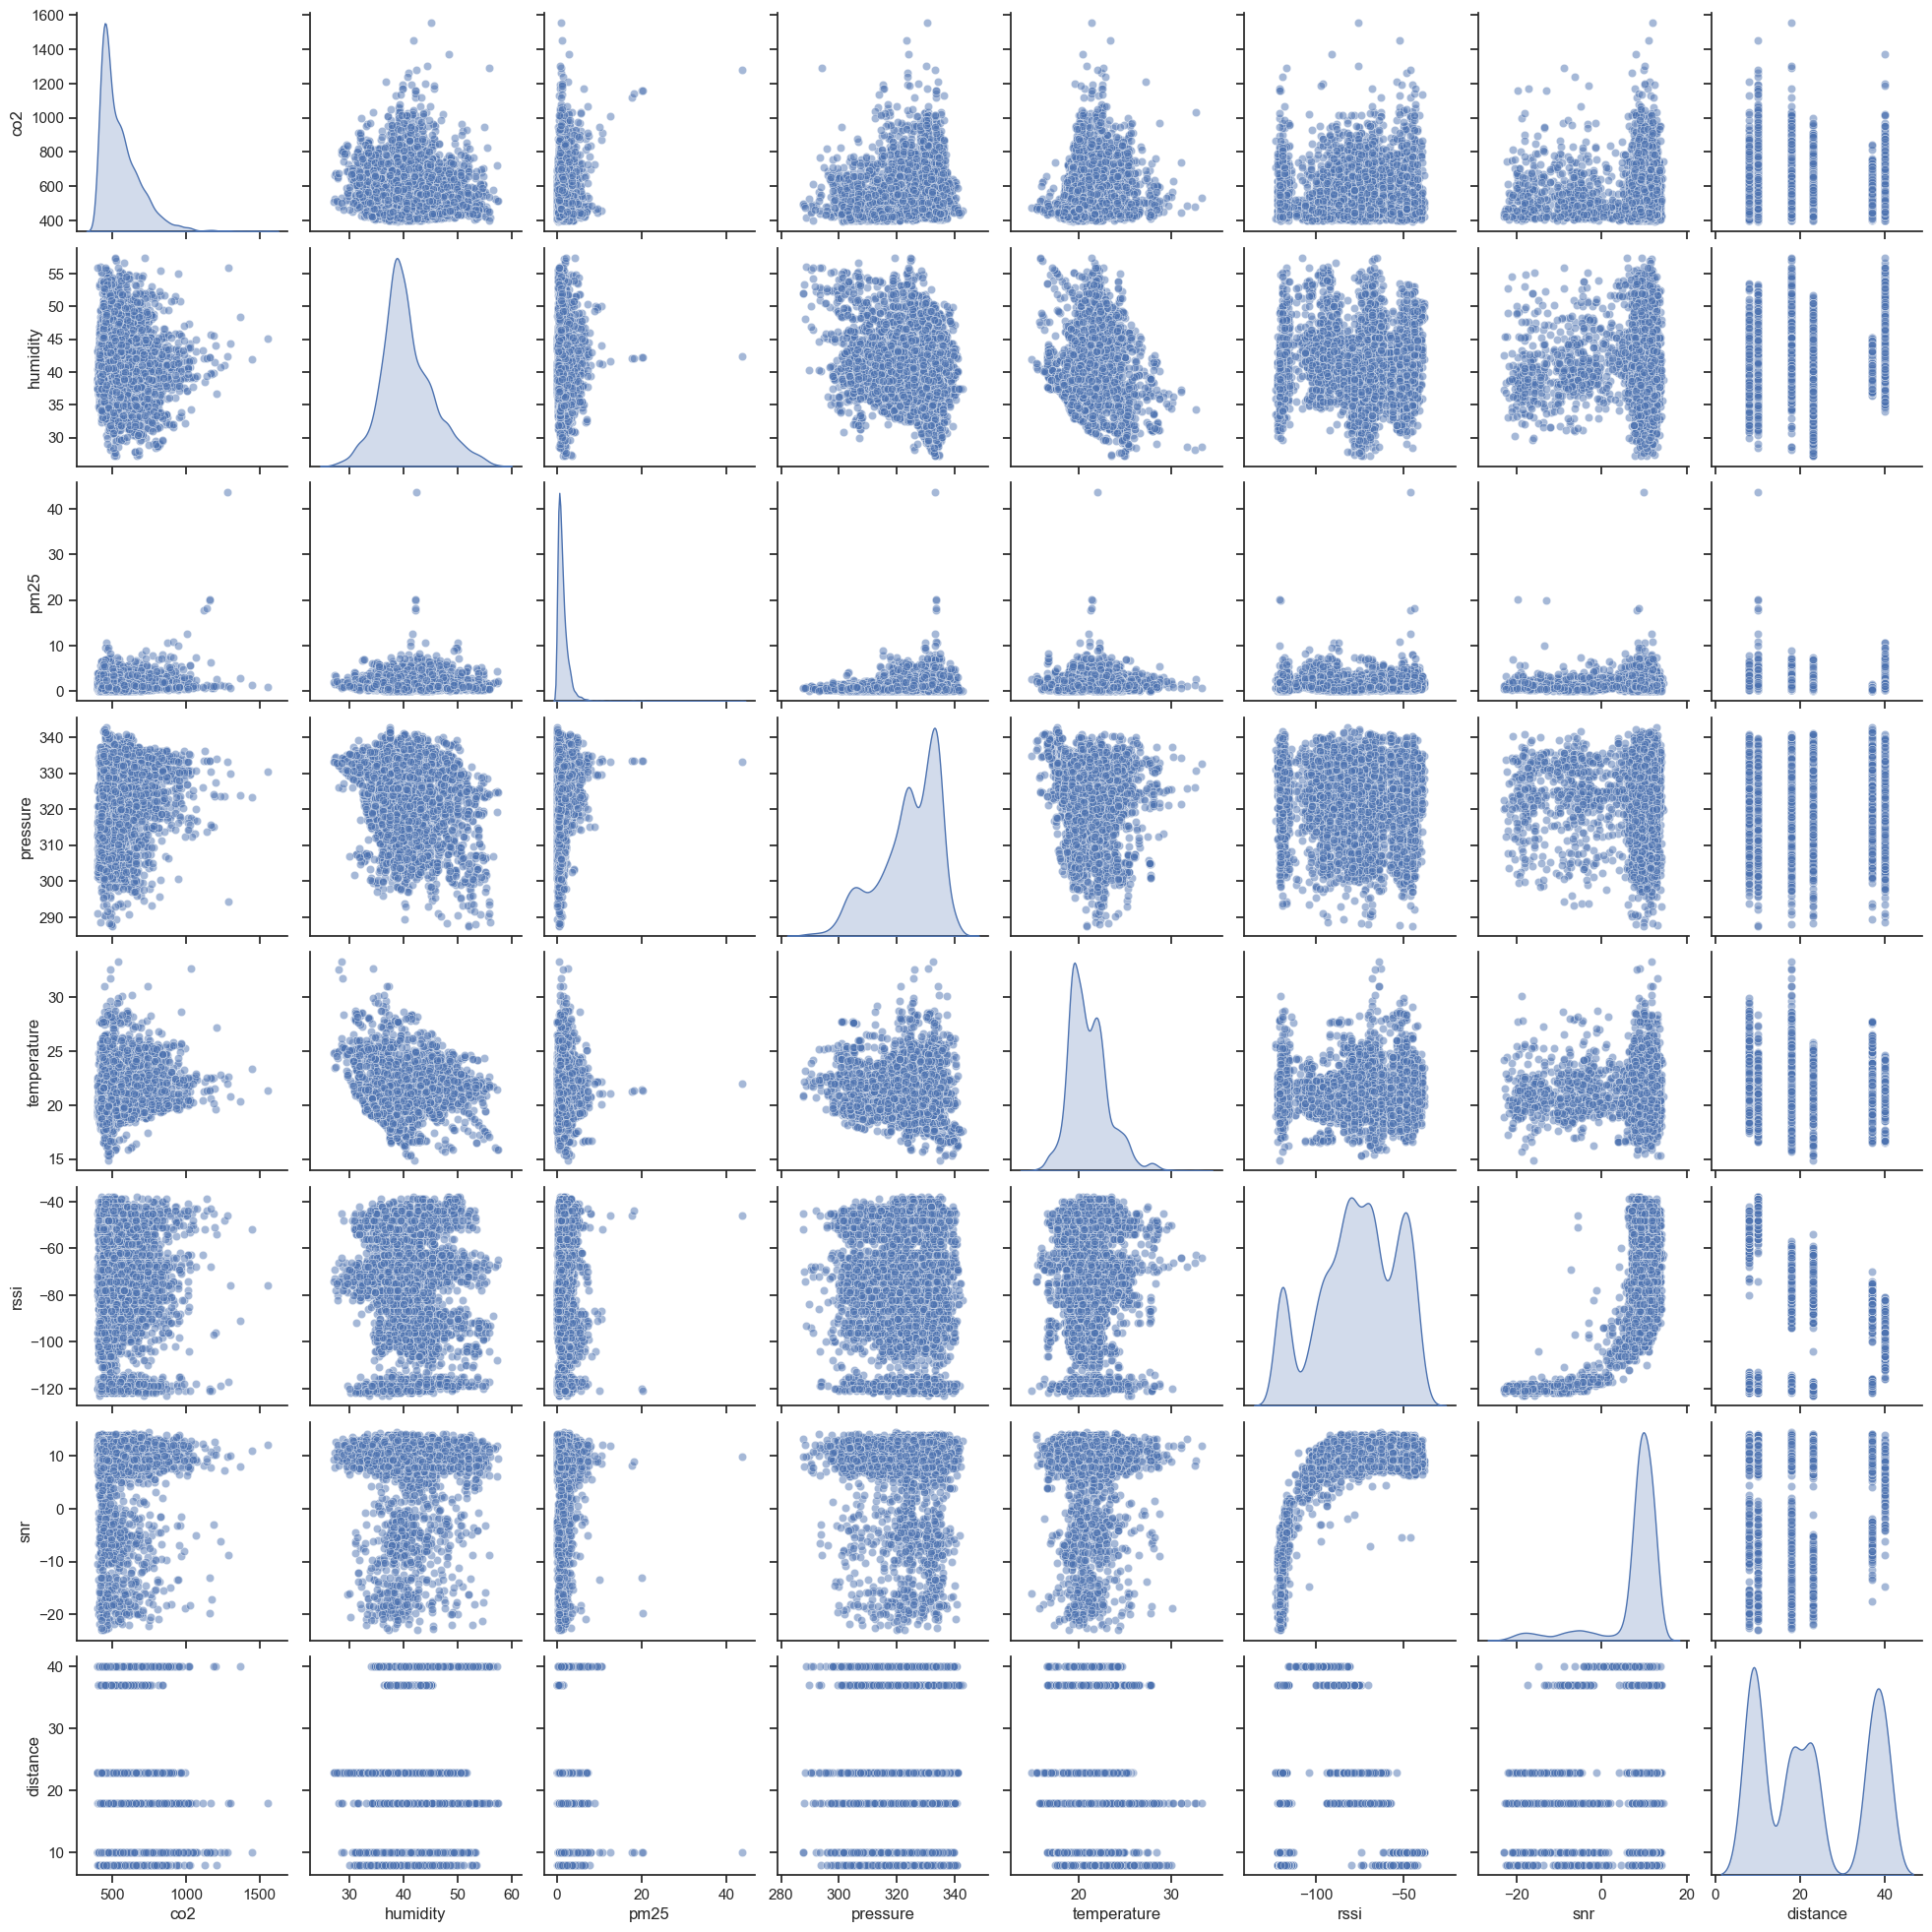

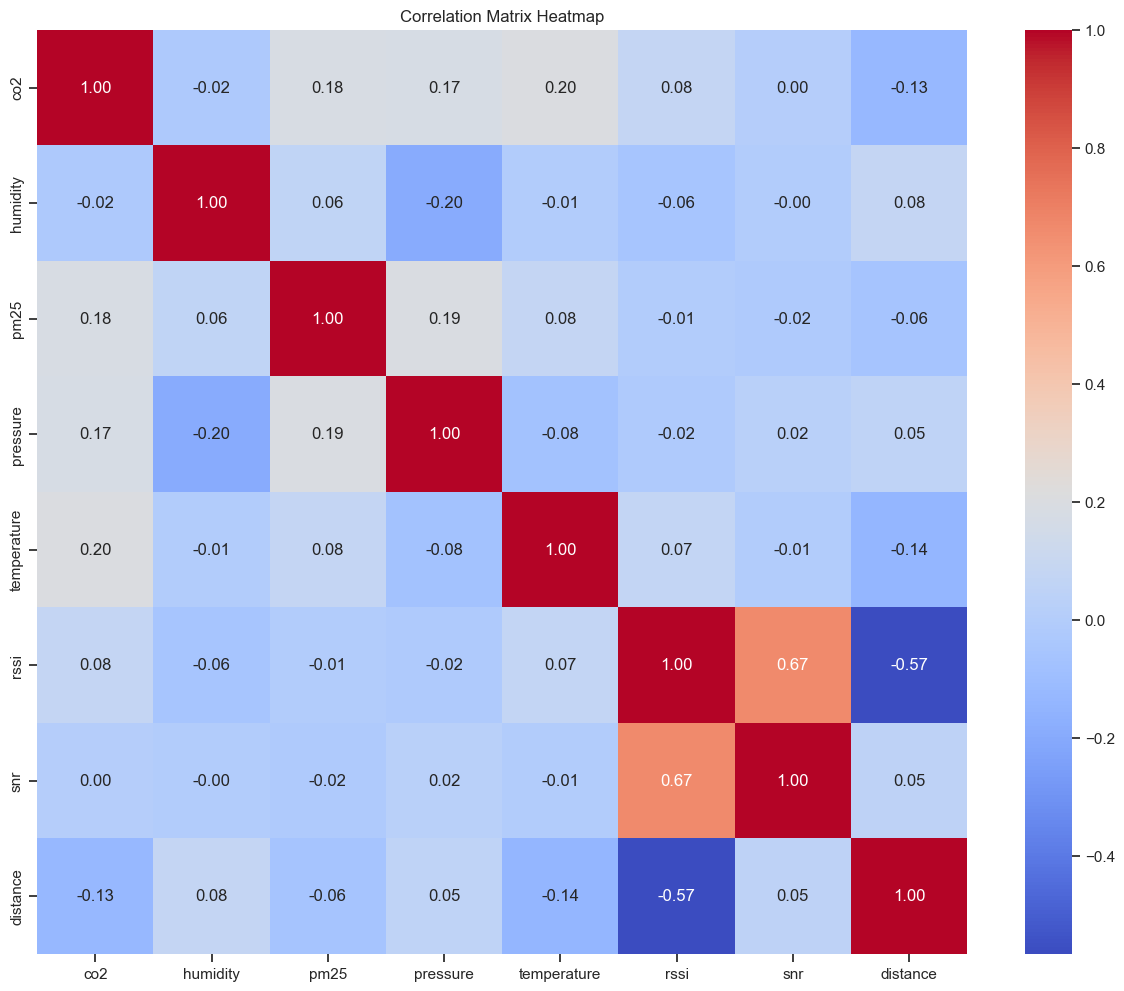

In [14]:
# Sample the DataFrame
sample_size = 5000
cleaned_df_sample = cleaned_df.sample(n=sample_size, random_state=42)

# Select Numerical Columns
numerical_cols = [
    'co2', 'humidity', 'pm25', 'pressure', 'temperature',
    'rssi', 'snr', 'distance'
]
numerical_cols = [col for col in numerical_cols if col in cleaned_df_sample.columns]
pairplot_df = cleaned_df_sample[numerical_cols]

# Create Pair Plot
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(20, 20))
pair_plot = sns.pairplot(pairplot_df, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

# Correlation Heatmap
corr_matrix = pairplot_df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Overal Correlation Matrix
</p>

In [15]:
# Select only the numeric columns
numeric_df = cleaned_df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Set the display format for floating-point numbers to xx decimal places
pd.options.display.float_format = '{:,.3f}'.format 

# Display the Correlation Matrix
correlation_matrix

,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
co2,1.000,-0.001,0.119,0.183,0.209,0.088,0.008,0.000,0.000,0.088,0.088,0.000,-0.142,-0.063,-0.094,-0.088,0.092,0.077
humidity,-0.001,1.000,0.066,-0.193,0.025,-0.071,-0.015,0.001,0.001,-0.522,-0.525,0.000,0.083,0.257,-0.020,0.071,-0.071,-0.062
pm25,0.119,0.066,1.000,0.123,0.062,0.004,-0.003,0.000,0.001,-0.073,-0.077,-0.001,-0.035,0.194,-0.177,-0.004,0.007,0.005
pressure,0.183,-0.193,0.123,1.000,-0.087,-0.018,0.006,0.000,0.000,0.166,0.167,-0.001,0.029,-0.025,0.053,0.018,-0.021,-0.016
temperature,0.209,0.025,0.062,-0.087,1.000,0.071,-0.006,0.001,-0.000,-0.566,-0.566,0.000,-0.138,-0.091,-0.087,-0.071,0.079,0.063
rssi,0.088,-0.071,0.004,-0.018,0.071,1.000,0.665,-0.281,-0.002,-0.001,0.004,-0.350,-0.565,-0.290,-0.437,-1.000,0.992,0.993
snr,0.008,-0.015,-0.003,0.006,-0.006,0.665,1.000,-0.374,-0.069,0.025,0.025,-0.497,0.044,-0.003,0.037,-0.665,0.576,0.746
SF,0.000,0.001,0.000,0.000,0.001,-0.281,-0.374,1.000,0.079,0.000,-0.000,0.907,-0.001,0.002,-0.003,0.281,-0.252,-0.309
frequency,0.000,0.001,0.001,0.000,-0.000,-0.002,-0.069,0.079,1.000,0.000,0.000,0.086,0.002,0.003,0.000,0.002,0.015,-0.007
f_count,0.088,-0.522,-0.073,0.166,-0.566,-0.001,0.025,0.000,0.000,1.000,1.000,-0.000,0.019,0.018,0.004,0.001,-0.008,0.000


In [16]:
#Single out PL and sort the values
numeric_df.corr()['exp_pl'].sort_values()

rssi          -1.000
esp           -0.993
n_power       -0.992
snr           -0.665
co2           -0.088
temperature   -0.071
p_count       -0.004
pm25          -0.004
f_count        0.001
frequency      0.002
pressure       0.018
humidity       0.071
SF             0.281
c_walls        0.290
toa            0.350
w_walls        0.437
distance       0.565
exp_pl         1.000
Name: exp_pl, dtype: float64

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Scatter Plots : SNR vs RSSI for each Devices
</p>

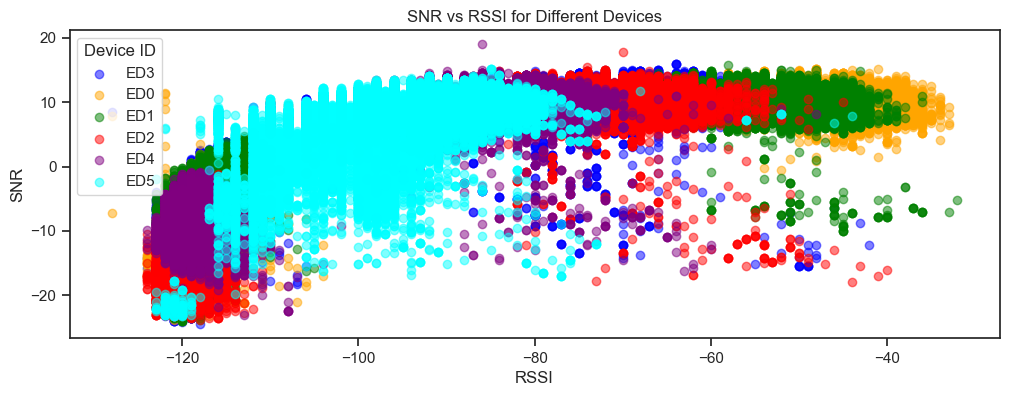

In [17]:
def plot_snr_vs_rssi(cleaned_df):
    """
    Plots SNR vs RSSI for each device dynamically using different colors.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data with 'rssi' and 'snr' columns.
    """
    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['blue', 'orange', 'green', 'red', 'purple', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])

    # Create a figure for plotting
    plt.figure(figsize=(12, 4))

    # Group by unique device IDs and assign colors dynamically
    for device, color in zip(cleaned_df['device_id'].unique(), color_pool):
        # Filter data for each device
        subset = cleaned_df[cleaned_df['device_id'] == device]
        # Scatter plot for SNR vs RSSI
        plt.scatter(subset['rssi'], subset['snr'], label=device, color=color, alpha=0.5)

    # Add labels, legend, and title
    plt.xlabel('RSSI')
    plt.ylabel('SNR')
    plt.legend(title='Device ID', loc='upper left')
    plt.title('SNR vs RSSI for Different Devices')

    # Show the plot
    plt.show()

# Example usage:
plot_snr_vs_rssi(cleaned_df)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Exploration of LoRAWAN Parameters based on the Spreading Factor
</p>

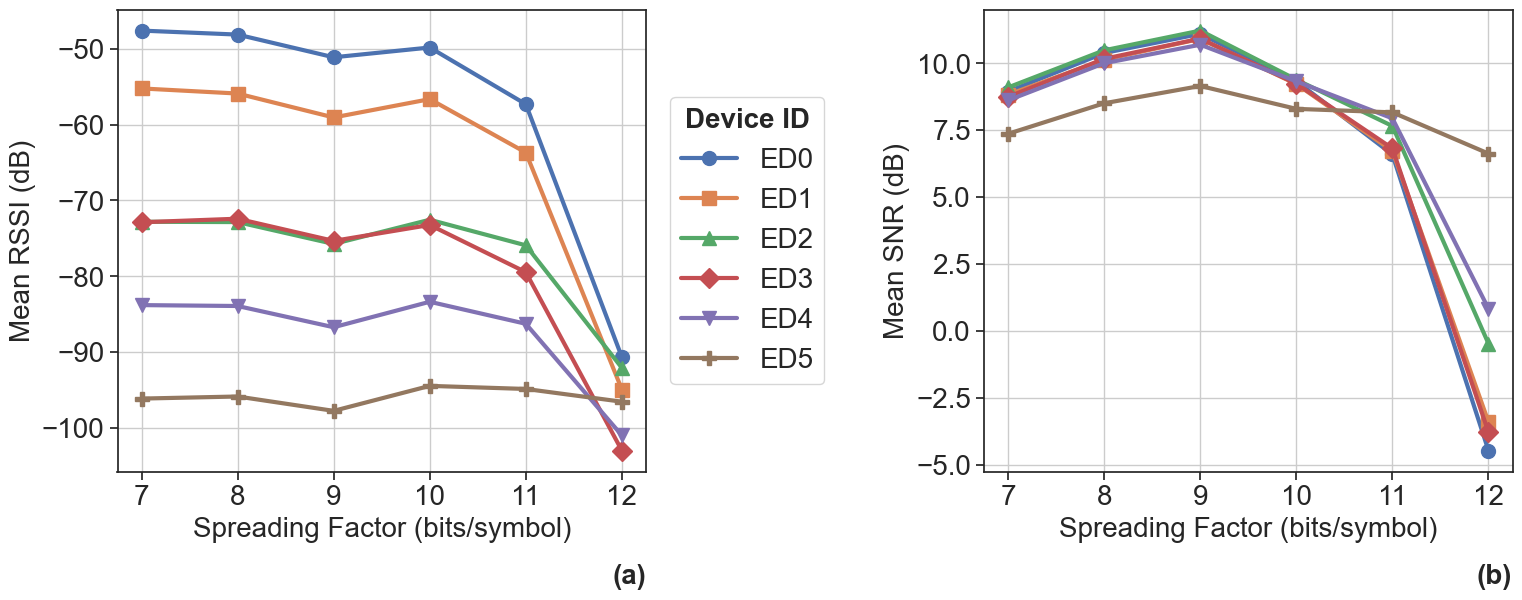

In [18]:
def plot_mean_metric(ax, cleaned_df, metric, ylabel, label=''):
    """
    Plots the mean of a specified metric grouped by Spreading Factor (SF) for each device.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - cleaned_df (DataFrame): DataFrame containing sensor data with 'device_id', 'SF', and metric columns.
    - metric (str): The metric to plot (e.g., 'rssi', 'snr', 'toa').
    - ylabel (str): The label for the y-axis.
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of markers to use for different devices
    marker_pool = itertools.cycle(['o', 's', '^', 'D', 'v', 'P', '*'])
    
    # Group by device and calculate mean metric for each SF
    for device_id, device_data in cleaned_df.groupby('device_id', observed=False):
        mean_metric = device_data.groupby('SF', observed=False)[metric].mean()
        # Plot mean metric for each device with a different marker
        ax.plot(mean_metric.index, mean_metric.values, marker=next(marker_pool), linestyle='-', markersize=10, linewidth=3, label=device_id)
    
    # Set axis labels with increased font size
    ax.set_xlabel('Spreading Factor (bits/symbol)', fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.grid(True)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    # Add subplot label (e.g., '(a)') with increased font size
    ax.text(1, -0.2, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Set up the matplotlib figure with GridSpec to allocate space for the legend
fig = plt.figure(figsize=(18, 6)) 

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 1], wspace=0.3)

# Add subplots for RSSI and SNR
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 2])

# Define subplot labels
subplot_labels = ['(a)', '(b)']

# Plot mean RSSI
plot_mean_metric(ax1, cleaned_df, 'rssi', 'Mean RSSI (dB)', label=subplot_labels[0])

# Plot mean SNR
plot_mean_metric(ax2, cleaned_df, 'snr', 'Mean SNR (dB)', label=subplot_labels[1])

# Collect handles and labels from both subplots
handles_a, labels_a = ax1.get_legend_handles_labels()
handles_b, labels_b = ax2.get_legend_handles_labels()

# Combine handles and labels, ensuring uniqueness
unique = OrderedDict()
for label, handle in zip(labels_a + labels_b, handles_a + handles_b):
    if label not in unique:
        unique[label] = handle
handles, labels = unique.values(), unique.keys()

# Create a separate axis for the legend in the middle column
legend_ax = fig.add_subplot(gs[0, 1])
legend_ax.axis('off')  # Hide the axis

# Add the common legend to the legend axis
legend = legend_ax.legend(
    handles, labels, 
    title='Device ID', 
    fontsize=20, 
    title_fontsize=20, 
    loc='center left',  
    bbox_to_anchor=(-1.0, 0.5), 
    ncol=1
)

legend.get_title().set_fontweight('bold')

# Adjust layout to ensure everything fits without overlapping
# plt.tight_layout()

# Save the figure 
plt.savefig('../all_data_files/rssi_and_snr_per_SF.png', dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()

In [19]:
# Calculate the mean of rssi, snr and exp_pl grouped by device_id
mean_values = cleaned_df.groupby('device_id', observed=False)[['rssi', 'snr', 'exp_pl']].mean()

# Display the mean values
mean_values

,rssi,snr,exp_pl
device_id,,,
ED0,-56.330,7.366,73.730
ED1,-63.190,7.451,80.590
ED2,-76.543,8.182,93.943
ED3,-78.623,7.374,96.023
ED4,-87.119,8.140,104.519
ED5,-95.992,8.058,113.392


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 KDE Plots: Environmental Parameters & LoRaWAN Signal PARAMETERS
</p>

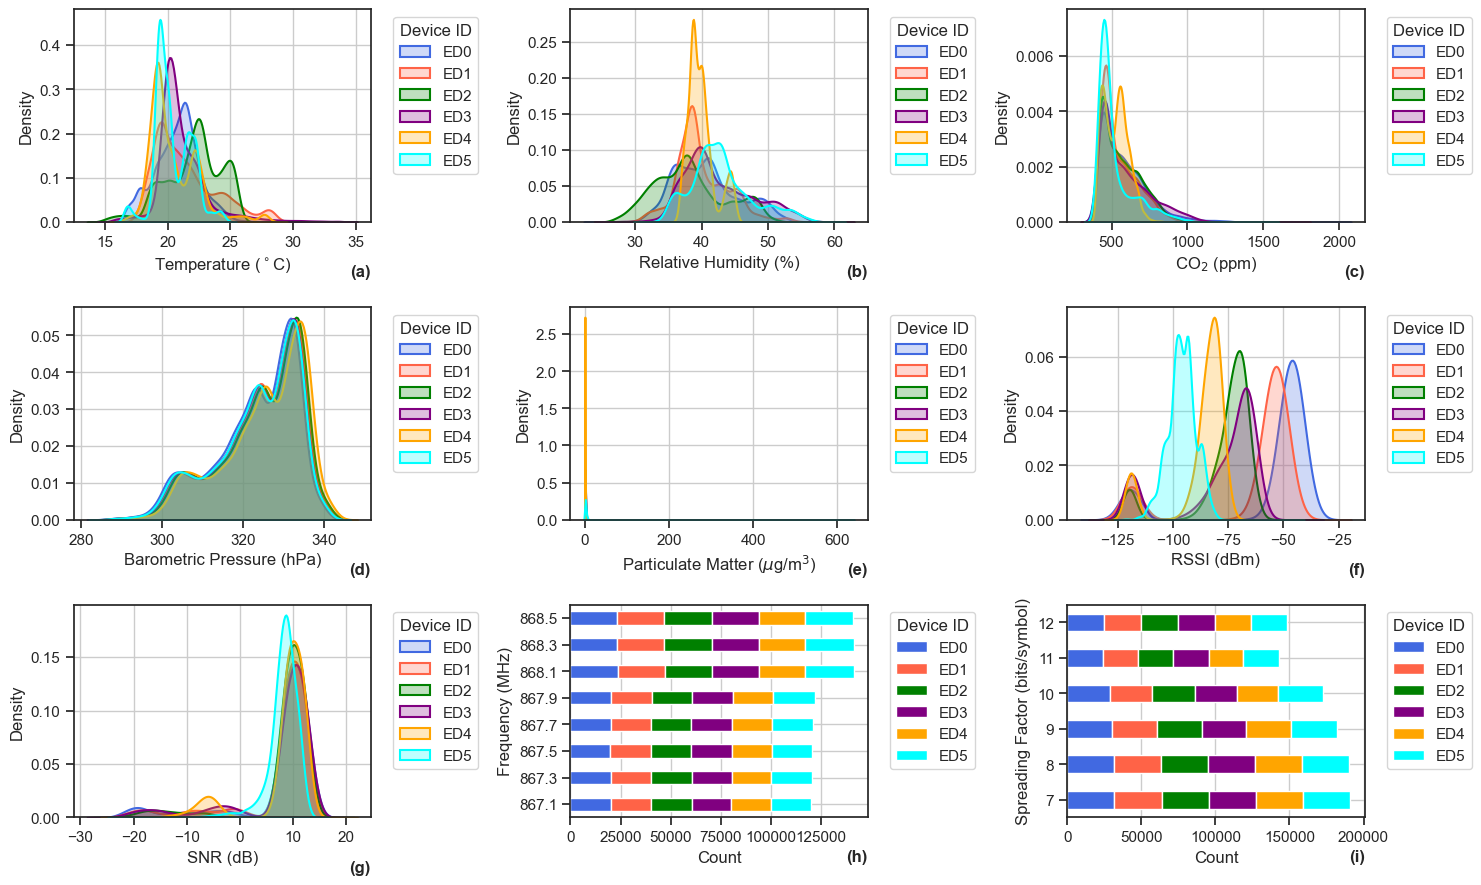

In [20]:
# Define labels with units and formatting
labels = {
    'temperature': 'Temperature ($^\circ$C)',
    'humidity': 'Relative Humidity (%)',
    'co2': 'CO$_2$ (ppm)',
    'pressure': 'Barometric Pressure (hPa)',
    'pm25': 'Particulate Matter ($\mu$g/m$^3$)',
    'rssi': 'RSSI (dBm)',
    'snr': 'SNR (dB)',
    'frequency': 'Frequency (MHz)',
    'SF': 'Spreading Factor (bits/symbol)'
}

def plot_stacked_bar(ax, data, parameter, label=''):
    """
    Plots a stacked bar chart for the given parameter, grouping by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'frequency', 'SF', 'distance').
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of colors to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Pivot the data to have device_id as columns
    pivot_data = data.pivot_table(index=parameter, columns='device_id', aggfunc='size', fill_value=0, observed=False)
    
    # Sort device_ids alphabetically
    device_ids = sorted(pivot_data.columns)
    
    # Create a color map dynamically based on sorted device_ids
    colors = {device: next(color_pool) for device in device_ids}

    # Plot the stacked bar plot
    pivot_data[device_ids].plot(kind='barh', stacked=True, ax=ax, color=[colors[device] for device in device_ids])
    
    ax.set_xlabel('Count')
    ax.set_ylabel(labels[parameter])
    ax.grid(True)
    
    # Sort the legend entries alphabetically
    handles, labels_ = ax.get_legend_handles_labels()
    sorted_labels, sorted_handles = zip(*sorted(zip(labels_, handles)))
    ax.legend(sorted_handles, sorted_labels, title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add subplot label
    ax.text(1, -0.15, label, transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=12)

def plot_kde(ax, data, parameter, bw_adjust=2, label=''):
    """
    Plots a Kernel Density Estimate (KDE) for the given parameter, grouped by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'temperature', 'humidity', 'co2').
    - bw_adjust (float): Bandwidth adjustment for the KDE plot.
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of colours to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Get sorted device_ids
    device_ids = sorted(data['device_id'].unique())
    
    # Create a color map dynamically based on sorted device_ids
    colors = {device_id: next(color_pool) for device_id in device_ids}
    
    # Plot KDE for each device, sorted by device_id
    for device_id in device_ids:
        subset = data[data['device_id'] == device_id]
        sns.kdeplot(
            subset[parameter], ax=ax, 
            label=device_id, 
            lw=1.5, 
            bw_adjust=bw_adjust, 
            fill=True, 
            color=colors[device_id]
        )
    
    ax.set_xlabel(labels[parameter])
    ax.set_ylabel('Density')
    ax.grid(True)
    
    # Sort the legend entries alphabetically
    handles, labels_ = ax.get_legend_handles_labels()
    sorted_labels, sorted_handles = zip(*sorted(zip(labels_, handles)))
    ax.legend(sorted_handles, sorted_labels, title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add subplot label
    ax.text(1, -0.2, label, transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=12)

# Filter the DataFrame
filtered_df = cleaned_df[cleaned_df['device_id'].isin(cleaned_df['device_id'].unique())]

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 9))  # Increased figure height for better spacing

# Define subplot labels
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

# Plot each parameter on a separate subplot with corresponding labels
plot_kde(axes[0, 0], filtered_df, 'temperature', bw_adjust=2, label=subplot_labels[0])
plot_kde(axes[0, 1], filtered_df, 'humidity', bw_adjust=2, label=subplot_labels[1])
plot_kde(axes[0, 2], filtered_df, 'co2', bw_adjust=2, label=subplot_labels[2])
plot_kde(axes[1, 0], filtered_df, 'pressure', bw_adjust=2, label=subplot_labels[3])
plot_kde(axes[1, 1], filtered_df, 'pm25', bw_adjust=2, label=subplot_labels[4])
plot_kde(axes[1, 2], filtered_df, 'rssi', bw_adjust=2, label=subplot_labels[5])
plot_kde(axes[2, 0], filtered_df, 'snr', bw_adjust=2, label=subplot_labels[6])

# Plot the stacked bar charts on the last two subplots with corresponding labels
plot_stacked_bar(axes[2, 1], filtered_df, 'frequency', label=subplot_labels[7])
plot_stacked_bar(axes[2, 2], filtered_df, 'SF', label=subplot_labels[8])

# Ensure proper spacing between rows by adjusting the layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Space between rows

# Save the figure
plt.savefig('../all_data_files/signal_environmental_dist.png', dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 LoRaWAN Effective Signal Power vs Noise Power
</p>

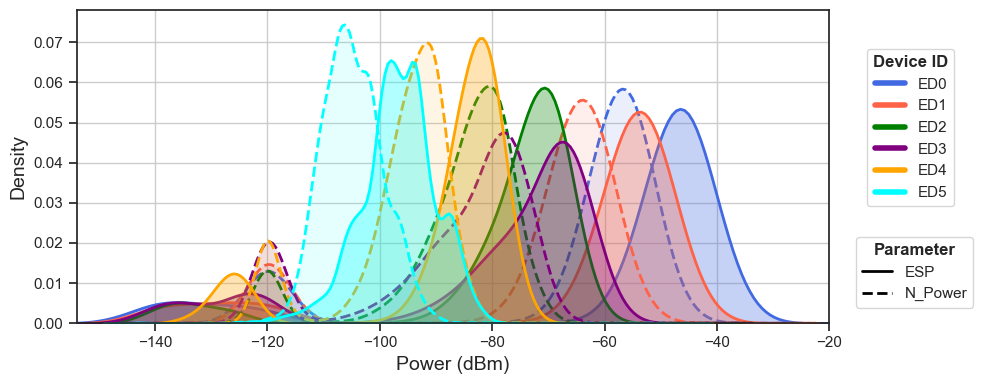

In [21]:
def plot_esp_n_power_comparison(ax, data, bw_adjust=2, title='ESP vs N_Power Distribution per Device'):
    """
    Compare 'esp' and 'n_power' distributions per device using KDE plots.
    'ESP' is dashed and 'N_Power' is solid.
    """
    # Assign colors to each device
    color_pool = cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'olive', 'pink'])
    devices = sorted(data['device_id'].unique())
    colors = {device: next(color_pool) for device in devices}
    
    for device in devices:
        subset = data[data['device_id'] == device]
        # Plot 'ESP' with solid line
        sns.kdeplot(
            subset['esp'], ax=ax, label=f'{device} - ESP', lw=2, bw_adjust=bw_adjust,
            linestyle='-', color=colors[device], fill=True, alpha=0.3
        )
        # Plot 'N_Power' with dashed line
        sns.kdeplot(
            subset['n_power'], ax=ax, label=f'{device} - N_Power', lw=2, bw_adjust=bw_adjust,
            linestyle='--', color=colors[device], fill=True, alpha=0.1
        )
    
    # Set titles and labels
    #  ax.set_title(title)
    ax.set_xlabel('Power (dBm)', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.grid(True)

    # Add x-axis limits
    ax.set_xlim(-154, -20)
    
    # Create legends
    device_handles = [Line2D([0], [0], color=colors[device], lw=4) for device in devices]
    device_labels = devices
    parameter_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-'),
        Line2D([0], [0], color='black', lw=2, linestyle='--')
    ]
    parameter_labels = ['ESP', 'N_Power']
    
    # Add device legend
    legend1 = ax.legend(device_handles, device_labels, title='Device ID',
                        bbox_to_anchor=(1.04, 0.9), loc='upper left')
    legend1.get_title().set_fontweight('bold') 
    ax.add_artist(legend1)
    
    # Add parameter legend
    legend2 = ax.legend(parameter_handles, parameter_labels, title='Parameter',
                        bbox_to_anchor=(1.025, 0.3), loc='upper left')
    legend2.get_title().set_fontweight('bold') 
    

# Plotting the comparison
fig, ax = plt.subplots(figsize=(10, 4))
plot_esp_n_power_comparison(ax, filtered_df, bw_adjust=2, title='ESP vs N_Power Distribution per Device')
plt.tight_layout()

# Save the plot
plt.savefig('../all_data_files/esp_n_power_comparison.png', dpi=1000)

# Display the plot
plt.show()